In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
np.random.seed(67)

print("✓ Libraries loaded")
print("✓ Random seed: 67")

✓ Libraries loaded
✓ Random seed: 67


## 0. Load Data from Notebook 00

In [2]:
# Load 24-item export from Notebook 00
with open('../data/airs_24item_complete.json', 'r', encoding='utf-8') as f:
    airs_24item_export = json.load(f)

# Load semantic metadata
with open('../data/airs_item_semantic_metadata.json', 'r', encoding='utf-8') as f:
    item_semantic_metadata = json.load(f)

# Load development sample
df_dev = pd.read_csv('../data/AIRS_clean_dev.csv')

# Extract structure
all_items = airs_24item_export['items']
construct_groups = airs_24item_export['constructs']
positive_items = airs_24item_export['positive_items']
negative_items = airs_24item_export['negative_items']

print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Development sample: N={len(df_dev)}")
print(f"Total items: {len(all_items)}")
print(f"  Positive (pro-adoption): {len(positive_items)}")
print(f"  Negative (anti-adoption): {len(negative_items)}")
print(f"Constructs: {len(construct_groups)}")
print("\nConstruct structure:")
for construct, items in sorted(construct_groups.items()):
    print(f"  {construct}: {items}")
print("="*70)

DATA LOADED
Development sample: N=131
Total items: 24
  Positive (pro-adoption): 21
  Negative (anti-adoption): 3
Constructs: 12

Construct structure:
  AX: ['AX1', 'AX2']
  EE: ['EE1', 'EE2']
  ER: ['ER1', 'ER2']
  EX: ['EX1', 'EX2']
  FC: ['FC1', 'FC2']
  HB: ['HB1', 'HB2']
  HM: ['HM1', 'HM2']
  PE: ['PE1', 'PE2']
  PV: ['PV1', 'PV2']
  SI: ['SI1', 'SI2']
  TR: ['TR1', 'TR2']
  VO: ['VO1', 'VO2']


In [3]:
# Prepare 24-item dataset
df_24items = df_dev[all_items].copy()

# Check for missing data
missing = df_24items.isnull().sum().sum()
print(f"Dataset: N={len(df_24items)}, Items={len(df_24items.columns)}")
print(f"Missing values: {missing}")

if missing > 0:
    df_24items = df_24items.dropna()
    print(f"After listwise deletion: N={len(df_24items)}")

Dataset: N=131, Items=24
Missing values: 0


## 1. Factorability Assessment

In [4]:
# KMO test
kmo_all, kmo_model = calculate_kmo(df_24items)

# Bartlett's test
chi_square_value, p_value = calculate_bartlett_sphericity(df_24items)

print("="*70)
print("FACTORABILITY ASSESSMENT")
print("="*70)
print(f"\nKaiser-Meyer-Olkin (KMO): {kmo_model:.3f}")
if kmo_model >= 0.90:
    print("  ✓ Marvelous - Excellent for factor analysis")
elif kmo_model >= 0.80:
    print("  ✓ Meritorious - Very good for factor analysis")
elif kmo_model >= 0.70:
    print("  ✓ Middling - Adequate for factor analysis")
elif kmo_model >= 0.60:
    print("  ✓ Mediocre - Acceptable for factor analysis")
else:
    print("  ⚠ Poor - Factor analysis may not be appropriate")

print(f"\nBartlett's Test of Sphericity")
print(f"  χ² = {chi_square_value:.2f}")
print(f"  p = {p_value:.2e}")
if p_value < 0.001:
    print("  ✓ Highly significant (p < .001) - Items are correlated")
else:
    print("  ⚠ Not significant - Factor analysis may not be appropriate")
    
print("\n" + "="*70)
print("VERDICT: Data is suitable for factor analysis" if kmo_model >= 0.60 and p_value < 0.001 else "VERDICT: Factor analysis not recommended")
print("="*70)

FACTORABILITY ASSESSMENT

Kaiser-Meyer-Olkin (KMO): 0.929
  ✓ Marvelous - Excellent for factor analysis

Bartlett's Test of Sphericity
  χ² = 3091.88
  p = 0.00e+00
  ✓ Highly significant (p < .001) - Items are correlated

VERDICT: Data is suitable for factor analysis


## 2. Determine Number of Factors

In [5]:
# Extract eigenvalues
fa_unrotated = FactorAnalyzer(n_factors=len(df_24items.columns), rotation=None, method='minres')
fa_unrotated.fit(df_24items)
eigenvalues, variance = fa_unrotated.get_eigenvalues()

# Kaiser criterion
kaiser_factors = sum(eigenvalues > 1.0)

# Parallel analysis (Monte Carlo simulation)
n_iterations = 100
random_eigenvalues = []
for _ in range(n_iterations):
    random_data = np.random.normal(size=df_24items.shape)
    fa_random = FactorAnalyzer(n_factors=len(df_24items.columns), rotation=None, method='minres')
    fa_random.fit(random_data)
    random_ev = fa_random.get_eigenvalues()[0]
    random_eigenvalues.append(random_ev)

random_eigenvalues_95th = np.percentile(random_eigenvalues, 95, axis=0)
parallel_factors = sum(eigenvalues > random_eigenvalues_95th)

print("="*70)
print("FACTOR RETENTION CRITERIA")
print("="*70)
print(f"\nKaiser Criterion (eigenvalue > 1.0): {kaiser_factors} factors")
print(f"Parallel Analysis (vs random data): {parallel_factors} factors ← RECOMMENDED")
print(f"\nFirst 8 eigenvalues: {', '.join([f'{ev:.3f}' for ev in eigenvalues[:8]])}")
print("\nVariance explained by first 5 factors:")
for i in range(5):
    cumvar = sum(eigenvalues[:i+1]) / sum(eigenvalues)
    print(f"  Factor {i+1}: {eigenvalues[i]:.3f} (Cumulative: {cumvar:.1%})")
print("="*70)

FACTOR RETENTION CRITERIA

Kaiser Criterion (eigenvalue > 1.0): 4 factors
Parallel Analysis (vs random data): 2 factors ← RECOMMENDED

First 8 eigenvalues: 13.698, 2.125, 1.378, 1.019, 0.681, 0.621, 0.539, 0.441

Variance explained by first 5 factors:
  Factor 1: 13.698 (Cumulative: 57.1%)
  Factor 2: 2.125 (Cumulative: 65.9%)
  Factor 3: 1.378 (Cumulative: 71.7%)
  Factor 4: 1.019 (Cumulative: 75.9%)
  Factor 5: 0.681 (Cumulative: 78.8%)


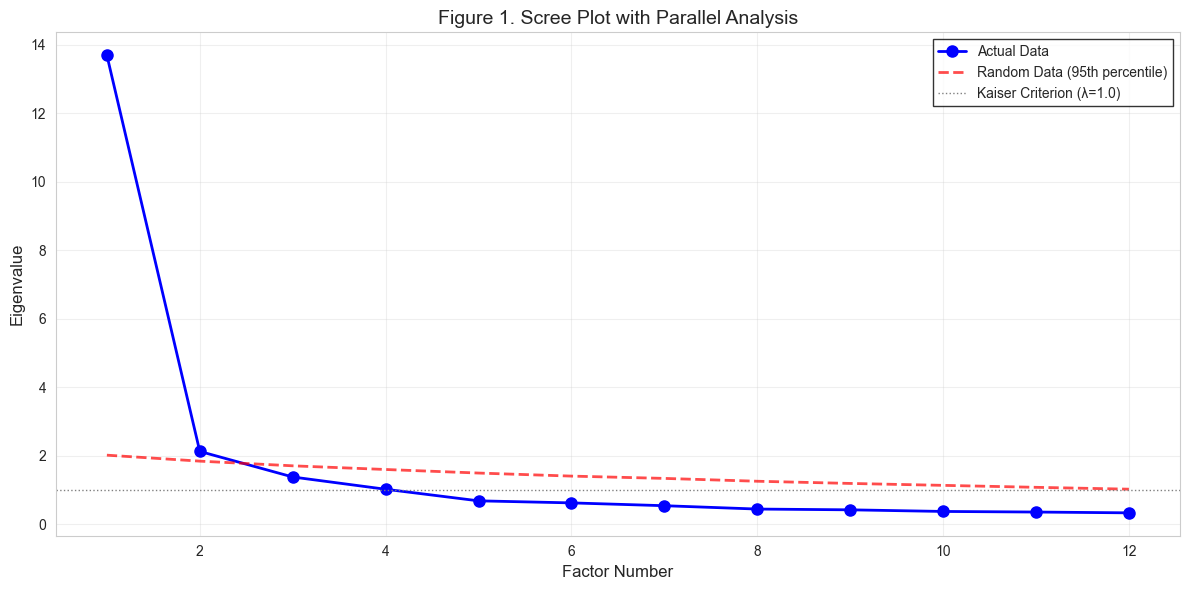

✓ Figure 1 saved: ../results/plots/scree_plot_24items.png


In [6]:
# Figure 1: Scree Plot with Parallel Analysis
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.plot(range(1, 13), eigenvalues[:12], 'bo-', linewidth=2, markersize=8, label='Actual Data')
ax.plot(range(1, 13), random_eigenvalues_95th[:12], 'r--', linewidth=2, alpha=0.7, label='Random Data (95th percentile)')
ax.axhline(y=1.0, color='gray', linestyle=':', linewidth=1, label='Kaiser Criterion (λ=1.0)')
ax.set_xlabel('Factor Number', fontsize=12, family='sans-serif')
ax.set_ylabel('Eigenvalue', fontsize=12, family='sans-serif')
ax.set_title('Figure 1. Scree Plot with Parallel Analysis', fontsize=14, family='sans-serif')
ax.legend(fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax.grid(True, alpha=0.3)
ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('../results/plots/scree_plot_24items.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 1 saved: ../results/plots/scree_plot_24items.png")

## 3. Test Factor Solutions

In [7]:
# Test 2, 3, and 4-factor solutions
solutions = {}

print("="*70)
print("TESTING FACTOR SOLUTIONS")
print("="*70)

for n_factors in [2, 3, 4]:
    print(f"\n{'='*70}")
    print(f"{n_factors}-FACTOR SOLUTION")
    print("="*70)
    
    # Fit model
    fa = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='minres')
    fa.fit(df_24items)
    
    # Get loadings
    loadings = pd.DataFrame(
        fa.loadings_,
        index=all_items,
        columns=[f'F{i+1}' for i in range(n_factors)]
    )
    
    # Variance explained
    variance_info = fa.get_factor_variance()
    total_variance = variance_info[2][-1]  # Cumulative proportion
    
    # Strong loadings (≥0.50)
    strong_loadings = (loadings.abs() >= 0.50).sum().sum()
    
    # Factor sizes (items with primary loading ≥0.50)
    factor_sizes = []
    for i in range(n_factors):
        col = f'F{i+1}'
        # Items where this factor has the highest loading AND ≥0.50
        primary = loadings[loadings[col].abs() >= 0.50]
        primary = primary[primary.abs().idxmax(axis=1) == col]
        factor_sizes.append(len(primary))
    
    print(f"\nVariance Explained: {total_variance:.1%}")
    print(f"Strong loadings (≥0.50): {strong_loadings}/{len(all_items)}")
    print(f"Factor sizes: {factor_sizes}")
    print(f"Minimum factor size: {min(factor_sizes)}")
    
    if min(factor_sizes) < 3:
        print("  ⚠ WARNING: Under-identification (factor with <3 items)")
    
    # Store solution
    solutions[n_factors] = {
        'fa': fa,
        'loadings': loadings,
        'variance': total_variance,
        'strong_loadings': strong_loadings,
        'factor_sizes': factor_sizes,
        'min_size': min(factor_sizes)
    }

print("\n" + "="*70)
print("SOLUTION COMPARISON")
print("="*70)
for n in [2, 3, 4]:
    print(f"\n{n}-Factor:")
    print(f"  Variance: {solutions[n]['variance']:.1%}")
    print(f"  Strong loadings: {solutions[n]['strong_loadings']}/{len(all_items)}")
    print(f"  Factor sizes: {solutions[n]['factor_sizes']}")
    print(f"  Status: {'✓ Identified' if solutions[n]['min_size'] >= 3 else '⚠ Under-identified'}")

TESTING FACTOR SOLUTIONS

2-FACTOR SOLUTION

Variance Explained: 62.4%
Strong loadings (≥0.50): 23/24
Factor sizes: [19, 4]
Minimum factor size: 4

3-FACTOR SOLUTION

Variance Explained: 61.8%
Strong loadings (≥0.50): 22/24
Factor sizes: [17, 4, 1]
Minimum factor size: 1
  ⚠ WARNING: Under-identification (factor with <3 items)

4-FACTOR SOLUTION

Variance Explained: 60.5%
Strong loadings (≥0.50): 24/24
Factor sizes: [13, 4, 4, 2]
Minimum factor size: 2
  ⚠ WARNING: Under-identification (factor with <3 items)

SOLUTION COMPARISON

2-Factor:
  Variance: 62.4%
  Strong loadings: 23/24
  Factor sizes: [19, 4]
  Status: ✓ Identified

3-Factor:
  Variance: 61.8%
  Strong loadings: 22/24
  Factor sizes: [17, 4, 1]
  Status: ⚠ Under-identified

4-Factor:
  Variance: 60.5%
  Strong loadings: 24/24
  Factor sizes: [13, 4, 4, 2]
  Status: ⚠ Under-identified


## 4. Select Best Factor Solution

In [8]:
# Select best solution (use parallel analysis recommendation)
best_n_factors = parallel_factors

print("="*70)
print(f"SELECTED: {best_n_factors}-FACTOR SOLUTION")
print("="*70)
print(f"Rationale: Parallel analysis recommendation (gold standard)")
print(f"\nModel characteristics:")
print(f"  Variance explained: {solutions[best_n_factors]['variance']:.1%}")
print(f"  Strong loadings: {solutions[best_n_factors]['strong_loadings']}/{len(all_items)}")
print(f"  Factor sizes: {solutions[best_n_factors]['factor_sizes']}")
print("="*70)

# Get final loadings
final_loadings = solutions[best_n_factors]['loadings'].copy()
final_loadings['Primary_Factor'] = final_loadings.abs().idxmax(axis=1)
final_loadings['Max_Loading'] = final_loadings[[f'F{i+1}' for i in range(best_n_factors)]].abs().max(axis=1)

# Add construct information
final_loadings['Construct'] = final_loadings.index.map(lambda x: next((k for k, v in construct_groups.items() if x in v), 'Unknown'))
final_loadings['Direction'] = final_loadings.index.map(lambda x: item_semantic_metadata[x]['direction'])

print("\nLoadings by Factor:")
for i in range(best_n_factors):
    factor_col = f'F{i+1}'
    factor_items = final_loadings[final_loadings['Primary_Factor'] == factor_col].sort_values(factor_col, ascending=False, key=abs)
    print(f"\n{factor_col} (n={len(factor_items)}):")
    for idx, row in factor_items.iterrows():
        print(f"  {idx} ({row['Construct']}): {row[factor_col]:.3f} [{row['Direction']}]")

SELECTED: 2-FACTOR SOLUTION
Rationale: Parallel analysis recommendation (gold standard)

Model characteristics:
  Variance explained: 62.4%
  Strong loadings: 23/24
  Factor sizes: [19, 4]

Loadings by Factor:

F1 (n=20):
  HM2 (HM): 0.890 [POSITIVE]
  PV1 (PV): 0.872 [POSITIVE]
  HM1 (HM): 0.872 [POSITIVE]
  PE2 (PE): 0.871 [POSITIVE]
  HB2 (HB): 0.871 [POSITIVE]
  HB1 (HB): 0.869 [POSITIVE]
  TR2 (TR): 0.861 [POSITIVE]
  PV2 (PV): 0.860 [POSITIVE]
  PE1 (PE): 0.857 [POSITIVE]
  VO1 (VO): 0.855 [POSITIVE]
  TR1 (TR): 0.853 [POSITIVE]
  SI1 (SI): 0.847 [POSITIVE]
  EE2 (EE): 0.829 [POSITIVE]
  FC2 (FC): 0.806 [POSITIVE]
  SI2 (SI): 0.790 [POSITIVE]
  EX1 (EX): 0.755 [POSITIVE]
  FC1 (FC): 0.749 [POSITIVE]
  EE1 (EE): 0.731 [POSITIVE]
  EX2 (EX): 0.609 [POSITIVE]
  VO2 (VO): 0.283 [POSITIVE]

F2 (n=4):
  AX1 (AX): 0.743 [NEGATIVE]
  ER1 (ER): 0.651 [NEGATIVE]
  ER2 (ER): 0.579 [NEGATIVE]
  AX2 (AX): 0.545 [POSITIVE]


## 5. Iterative Item Reduction

In [9]:
# Iterative item reduction with stability checking
# Instead of aggressive threshold-based selection, we'll reduce items gradually
# and monitor factor structure stability at each step

print("="*70)
print("ITERATIVE ITEM REDUCTION WITH STABILITY MONITORING")
print("="*70)

# Start with all 24 items, remove weakest item iteratively
current_items = all_items.copy()
reduction_history = []

# Target: ~15-18 items (maintain factor structure)
min_items = 15
min_items_per_factor = 3

while len(current_items) > min_items:
    # Fit model with current items
    df_current = df_24items[current_items].copy()
    fa_current = FactorAnalyzer(n_factors=best_n_factors, rotation='promax', method='minres')
    fa_current.fit(df_current)
    
    # Get loadings
    loadings_current = pd.DataFrame(
        fa_current.loadings_,
        index=current_items,
        columns=[f'F{i+1}' for i in range(best_n_factors)]
    )
    
    # Calculate primary factor and max loading for each item
    loadings_current['Primary_Factor'] = loadings_current.abs().idxmax(axis=1)
    loadings_current['Max_Loading'] = loadings_current[[f'F{i+1}' for i in range(best_n_factors)]].abs().max(axis=1)
    
    # Count items per factor
    factor_counts_current = loadings_current['Primary_Factor'].value_counts()
    
    # Find weakest item that can be safely removed
    # Priority: remove items with low loadings, but maintain minimum 3 per factor
    candidates_for_removal = []
    
    for item_name, row in loadings_current.iterrows():
        primary_factor = row['Primary_Factor']
        max_loading = row['Max_Loading']
        factor_count = factor_counts_current.get(primary_factor, 0)
        
        # Can remove if: (1) not the last 3 items of its factor, (2) weakest loading
        if factor_count > min_items_per_factor:
            candidates_for_removal.append({
                'item': item_name,
                'factor': primary_factor,
                'loading': max_loading,
                'factor_count': factor_count
            })
    
    # If no candidates, we've reached minimum
    if not candidates_for_removal:
        print(f"\n✓ Stopping: All factors at minimum {min_items_per_factor} items")
        break
    
    # Remove item with weakest loading
    candidates_df = pd.DataFrame(candidates_for_removal).sort_values('loading')
    item_to_remove = candidates_df.iloc[0]['item']
    removal_loading = candidates_df.iloc[0]['loading']
    removal_factor = candidates_df.iloc[0]['factor']
    
    # Store history
    reduction_history.append({
        'n_items': len(current_items),
        'removed_item': item_to_remove,
        'removed_loading': removal_loading,
        'removed_factor': removal_factor,
        'factor_counts': factor_counts_current.to_dict()
    })
    
    # Remove item
    current_items.remove(item_to_remove)
    
    print(f"\nIteration {len(reduction_history)}: {len(current_items)+1} → {len(current_items)} items")
    print(f"  Removed: {item_to_remove} (loading={removal_loading:.3f}, factor={removal_factor})")
    print(f"  Factor distribution: {dict(factor_counts_current)}")

# Final selected items
selected_items = current_items

print("\n" + "="*70)
print(f"FINAL SELECTION: {len(selected_items)} ITEMS")
print("="*70)
print(f"\nSelected items: {', '.join(sorted(selected_items))}")

# Get final factor structure
df_final = df_24items[selected_items].copy()
fa_check = FactorAnalyzer(n_factors=best_n_factors, rotation='promax', method='minres')
fa_check.fit(df_final)

loadings_check = pd.DataFrame(
    fa_check.loadings_,
    index=selected_items,
    columns=[f'F{i+1}' for i in range(best_n_factors)]
)
loadings_check['Primary_Factor'] = loadings_check.abs().idxmax(axis=1)
loadings_check['Max_Loading'] = loadings_check[[f'F{i+1}' for i in range(best_n_factors)]].abs().max(axis=1)

print(f"\nFinal factor distribution:")
for i in range(best_n_factors):
    factor_col = f'F{i+1}'
    factor_items = loadings_check[loadings_check['Primary_Factor'] == factor_col]
    factor_item_names = sorted(factor_items.index.tolist())
    min_loading = factor_items['Max_Loading'].min()
    max_loading = factor_items['Max_Loading'].max()
    print(f"  {factor_col}: {len(factor_items)} items (loadings: {min_loading:.3f}-{max_loading:.3f})")
    print(f"    Items: {', '.join(factor_item_names)}")

# Calculate reduction
reduction_pct = (1 - len(selected_items) / len(all_items)) * 100
print(f"\nItem reduction: {len(all_items)} → {len(selected_items)} ({reduction_pct:.1f}% reduction)")
print("="*70)

# Store reduction history for analysis
print(f"\n✓ Reduction process: {len(reduction_history)} iterations")
print(f"✓ Items removed in order:")
for i, step in enumerate(reduction_history, 1):
    print(f"   {i}. {step['removed_item']} (λ={step['removed_loading']:.3f}, {step['removed_factor']})")

ITERATIVE ITEM REDUCTION WITH STABILITY MONITORING

Iteration 1: 24 → 23 items
  Removed: VO2 (loading=0.283, factor=F1)
  Factor distribution: {'F1': np.int64(20), 'F2': np.int64(4)}

Iteration 2: 23 → 22 items
  Removed: AX2 (loading=0.553, factor=F2)
  Factor distribution: {'F1': np.int64(19), 'F2': np.int64(4)}

Iteration 3: 22 → 21 items
  Removed: EX2 (loading=0.607, factor=F1)
  Factor distribution: {'F1': np.int64(19), 'F2': np.int64(3)}

Iteration 4: 21 → 20 items
  Removed: EE1 (loading=0.756, factor=F1)
  Factor distribution: {'F1': np.int64(18), 'F2': np.int64(3)}

Iteration 5: 20 → 19 items
Iteration 2: 23 → 22 items
  Removed: AX2 (loading=0.553, factor=F2)
  Factor distribution: {'F1': np.int64(19), 'F2': np.int64(4)}

Iteration 3: 22 → 21 items
  Removed: EX2 (loading=0.607, factor=F1)
  Factor distribution: {'F1': np.int64(19), 'F2': np.int64(3)}

Iteration 4: 21 → 20 items
  Removed: EE1 (loading=0.756, factor=F1)
  Factor distribution: {'F1': np.int64(18), 'F2': np.i

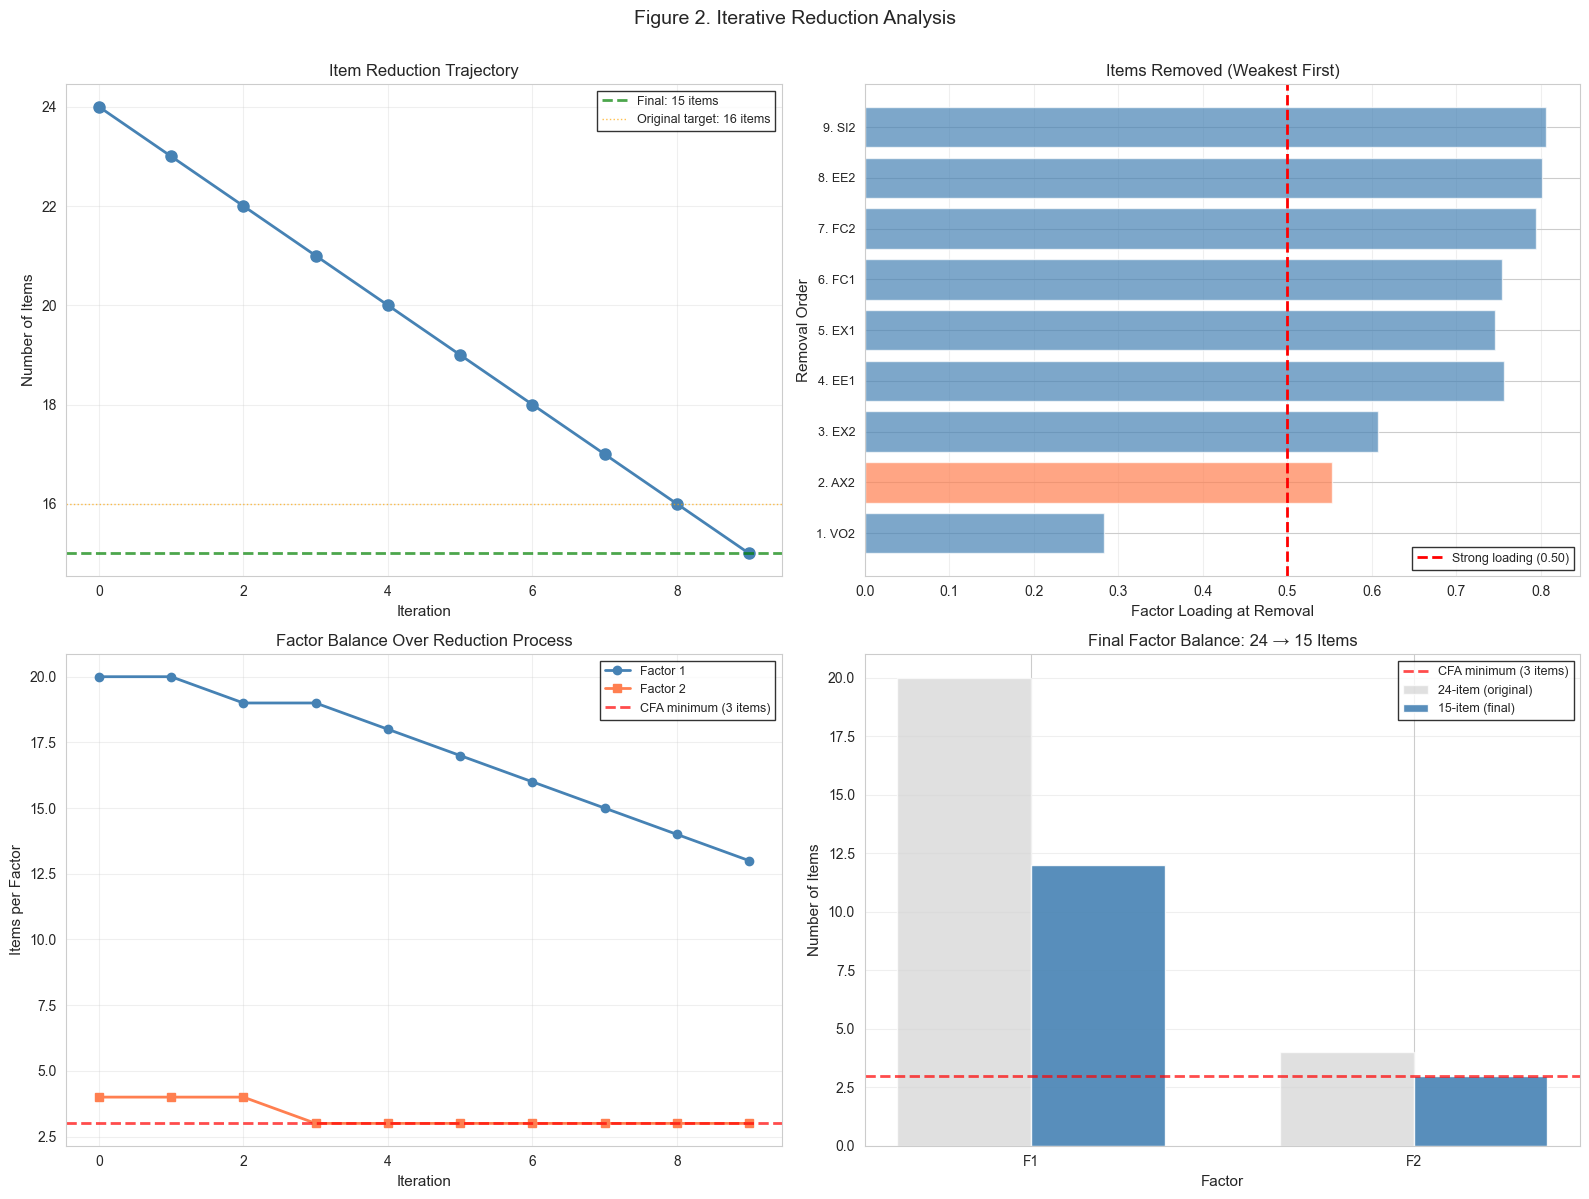

✓ Figure 2 saved: ../results/plots/iterative_reduction_analysis.png


In [10]:
# Figure 2: Iterative Reduction Process and Factor Stability
fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')

# Plot 1: Reduction trajectory (number of items over iterations)
if reduction_history:
    iterations = list(range(len(reduction_history) + 1))
    n_items_trajectory = [all_items.__len__()] + [step['n_items'] - 1 for step in reduction_history]
    
    axes[0, 0].plot(iterations, n_items_trajectory, 'o-', linewidth=2, markersize=8, color='steelblue')
    axes[0, 0].axhline(y=len(selected_items), color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Final: {len(selected_items)} items')
    axes[0, 0].axhline(y=16, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='Original target: 16 items')
    axes[0, 0].set_xlabel('Iteration', fontsize=11, family='sans-serif')
    axes[0, 0].set_ylabel('Number of Items', fontsize=11, family='sans-serif')
    axes[0, 0].set_title('Item Reduction Trajectory', fontsize=12, family='sans-serif')
    axes[0, 0].legend(fontsize=9, frameon=True, fancybox=False, edgecolor='black')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_facecolor('white')

# Plot 2: Loading distribution of removed items
if reduction_history:
    removed_loadings = [step['removed_loading'] for step in reduction_history]
    removed_factors = [step['removed_factor'] for step in reduction_history]
    
    colors_map = {'F1': 'steelblue', 'F2': 'coral'}
    colors = [colors_map.get(f, 'gray') for f in removed_factors]
    
    axes[0, 1].barh(range(len(removed_loadings)), removed_loadings, color=colors, alpha=0.7)
    axes[0, 1].axvline(x=0.50, color='red', linestyle='--', linewidth=2, label='Strong loading (0.50)')
    axes[0, 1].set_yticks(range(len(removed_loadings)))
    axes[0, 1].set_yticklabels([f"{i+1}. {step['removed_item']}" for i, step in enumerate(reduction_history)], fontsize=9, family='sans-serif')
    axes[0, 1].set_xlabel('Factor Loading at Removal', fontsize=11, family='sans-serif')
    axes[0, 1].set_ylabel('Removal Order', fontsize=11, family='sans-serif')
    axes[0, 1].set_title('Items Removed (Weakest First)', fontsize=12, family='sans-serif')
    axes[0, 1].legend(fontsize=9, frameon=True, fancybox=False, edgecolor='black')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    axes[0, 1].set_facecolor('white')

# Plot 3: Factor balance over iterations
if reduction_history:
    # Get initial factor counts from 24-item solution
    initial_factor_counts_24 = final_loadings['Primary_Factor'].value_counts()
    f1_counts = [initial_factor_counts_24.get('F1', 0)]
    f2_counts = [initial_factor_counts_24.get('F2', 0)]
    
    for step in reduction_history:
        factor_counts = step['factor_counts']
        f1_counts.append(factor_counts.get('F1', 0))
        f2_counts.append(factor_counts.get('F2', 0))
    
    iterations_extended = list(range(len(reduction_history) + 1))
    
    axes[1, 0].plot(iterations_extended, f1_counts, 'o-', linewidth=2, markersize=6, color='steelblue', label='Factor 1')
    axes[1, 0].plot(iterations_extended, f2_counts, 's-', linewidth=2, markersize=6, color='coral', label='Factor 2')
    axes[1, 0].axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='CFA minimum (3 items)')
    axes[1, 0].set_xlabel('Iteration', fontsize=11, family='sans-serif')
    axes[1, 0].set_ylabel('Items per Factor', fontsize=11, family='sans-serif')
    axes[1, 0].set_title('Factor Balance Over Reduction Process', fontsize=12, family='sans-serif')
    axes[1, 0].legend(fontsize=9, frameon=True, fancybox=False, edgecolor='black')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_facecolor('white')

# Plot 4: Final vs. original factor distribution
factor_counts_24 = final_loadings['Primary_Factor'].value_counts().sort_index()
factor_counts_final = loadings_check['Primary_Factor'].value_counts().sort_index()

x = np.arange(best_n_factors)
width = 0.35
axes[1, 1].bar(x - width/2, factor_counts_24, width, label='24-item (original)', alpha=0.7, color='lightgray')
axes[1, 1].bar(x + width/2, factor_counts_final, width, label=f'{len(selected_items)}-item (final)', alpha=0.9, color='steelblue')
axes[1, 1].axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='CFA minimum (3 items)')
axes[1, 1].set_xlabel('Factor', fontsize=11, family='sans-serif')
axes[1, 1].set_ylabel('Number of Items', fontsize=11, family='sans-serif')
axes[1, 1].set_title(f'Final Factor Balance: 24 → {len(selected_items)} Items', fontsize=12, family='sans-serif')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'F{i+1}' for i in range(best_n_factors)], family='sans-serif')
axes[1, 1].legend(fontsize=9, frameon=True, fancybox=False, edgecolor='black')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_facecolor('white')

fig.suptitle('Figure 2. Iterative Reduction Analysis', fontsize=14, family='sans-serif', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('../results/plots/iterative_reduction_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: ../results/plots/iterative_reduction_analysis.png")

## 6. Validate Final Scale

In [11]:
# Prepare reduced dataset
df_selected = df_24items[selected_items].copy()

# Re-run factorability tests
kmo_selected, kmo_model_selected = calculate_kmo(df_selected)
chi2_selected, p_selected = calculate_bartlett_sphericity(df_selected)

print("="*70)
print(f"VALIDATION: {len(selected_items)}-ITEM SCALE")
print("="*70)
print(f"\nFactorability:")
print(f"  KMO: {kmo_model_selected:.3f}")
print(f"  Bartlett's: χ²={chi2_selected:.2f}, p={p_selected:.2e}")

# Fit final model
fa_final = FactorAnalyzer(n_factors=best_n_factors, rotation='promax', method='minres')
fa_final.fit(df_selected)

# Get final loadings
loadings_final = pd.DataFrame(
    fa_final.loadings_,
    index=selected_items,
    columns=[f'F{i+1}' for i in range(best_n_factors)]
)
loadings_final['Primary_Factor'] = loadings_final.abs().idxmax(axis=1)
loadings_final['Max_Loading'] = loadings_final[[f'F{i+1}' for i in range(best_n_factors)]].abs().max(axis=1)

# Variance explained
variance_final = fa_final.get_factor_variance()
total_variance_final = variance_final[2][-1]

print(f"\nFactor Structure:")
print(f"  Total variance explained: {total_variance_final:.1%}")
print(f"  Strong loadings (≥0.50): {(loadings_final['Max_Loading'] >= 0.50).sum()}/{len(selected_items)}")
print(f"  Weak loadings (<0.50): {(loadings_final['Max_Loading'] < 0.50).sum()}/{len(selected_items)}")

# Reliability (Cronbach's alpha)
from sklearn.metrics import pairwise_distances
corr_matrix = df_selected.corr()
n_items = len(selected_items)
avg_corr = (corr_matrix.sum().sum() - n_items) / (n_items * (n_items - 1))
alpha = (n_items * avg_corr) / (1 + (n_items - 1) * avg_corr)

print(f"\nReliability:")
print(f"  Cronbach's α: {alpha:.3f}")
if alpha >= 0.90:
    print("  ✓ Excellent")
elif alpha >= 0.80:
    print("  ✓ Good")
elif alpha >= 0.70:
    print("  ✓ Acceptable")
else:
    print("  ⚠ Questionable")

print("="*70)

VALIDATION: 15-ITEM SCALE

Factorability:
  KMO: 0.931
  Bartlett's: χ²=2054.47, p=0.00e+00

Factor Structure:
  Total variance explained: 71.2%
  Strong loadings (≥0.50): 15/15
  Weak loadings (<0.50): 0/15

Reliability:
  Cronbach's α: 0.916
  ✓ Excellent


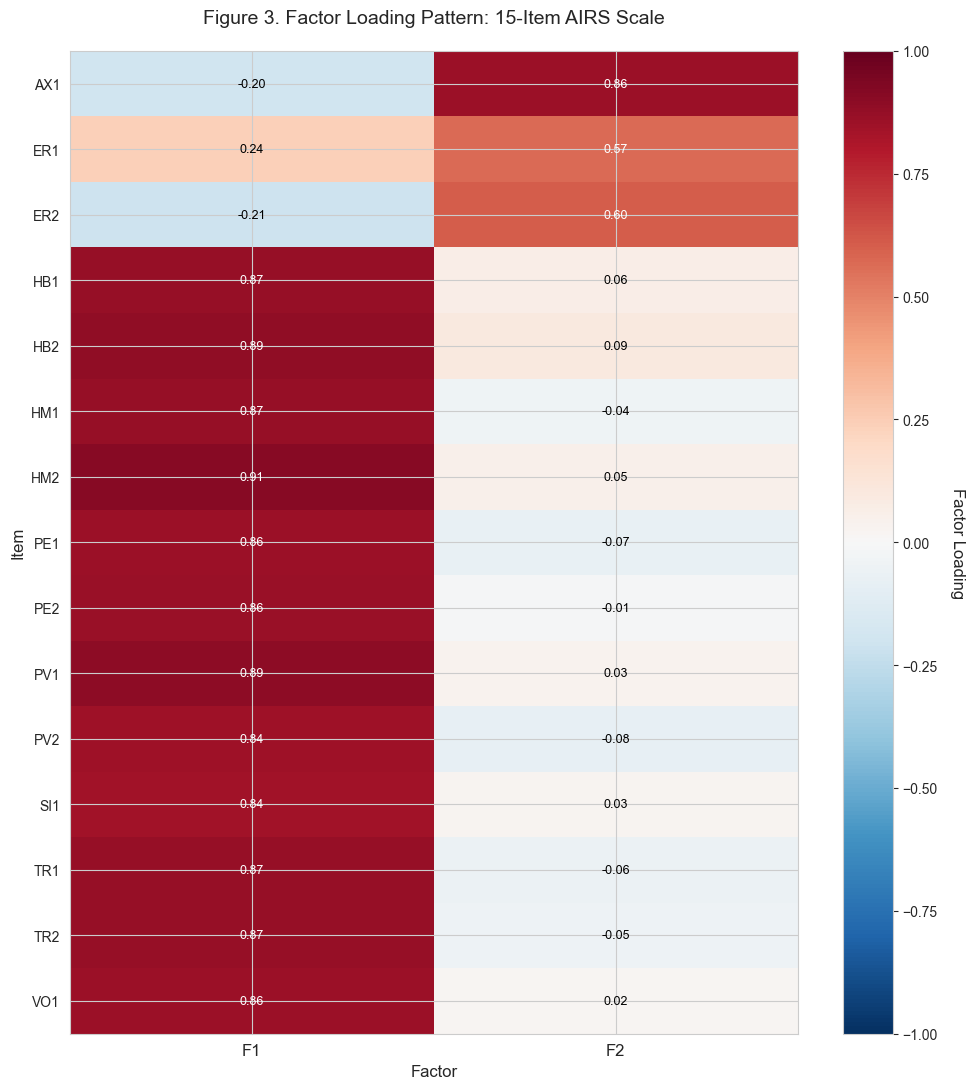

✓ Figure 3 saved: ../results/plots/loading_heatmap_15items.png

Loading Pattern Summary:
  Cross-loadings (|loading| ≥ 0.30 on secondary factor): 0/15 items
  Clean structure (single dominant loading): 15/15 items


In [12]:
# Figure 3: Factor Loading Pattern Heatmap
fig, ax = plt.subplots(figsize=(10, 11), facecolor='white')

# Create loading matrix for visualization
loading_matrix = loadings_final[[f'F{i+1}' for i in range(best_n_factors)]].copy()
loading_matrix = loading_matrix.reindex(sorted(loading_matrix.index))

# Create heatmap
im = ax.imshow(loading_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks
ax.set_xticks(np.arange(best_n_factors))
ax.set_yticks(np.arange(len(selected_items)))
ax.set_xticklabels([f'F{i+1}' for i in range(best_n_factors)], fontsize=12, family='sans-serif')
ax.set_yticklabels(sorted(selected_items), fontsize=10, family='sans-serif')

# Add values as text
for i in range(len(selected_items)):
    for j in range(best_n_factors):
        text_color = 'white' if abs(loading_matrix.iloc[i, j]) > 0.5 else 'black'
        ax.text(j, i, f'{loading_matrix.iloc[i, j]:.2f}',
               ha="center", va="center", color=text_color, fontsize=9, family='sans-serif')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Factor Loading', rotation=270, labelpad=20, fontsize=12, family='sans-serif')

# Labels and title
ax.set_xlabel('Factor', fontsize=12, family='sans-serif')
ax.set_ylabel('Item', fontsize=12, family='sans-serif')
ax.set_title(f'Figure 3. Factor Loading Pattern: {len(selected_items)}-Item AIRS Scale', fontsize=14, family='sans-serif', pad=20)
ax.set_facecolor('white')

plt.tight_layout()
plt.savefig('../results/plots/loading_heatmap_15items.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 3 saved: ../results/plots/loading_heatmap_15items.png")
print(f"\nLoading Pattern Summary:")
print(f"  Cross-loadings (|loading| ≥ 0.30 on secondary factor): {((loading_matrix.abs() >= 0.30).sum(axis=1) > 1).sum()}/{len(selected_items)} items")
print(f"  Clean structure (single dominant loading): {((loading_matrix.abs() >= 0.30).sum(axis=1) == 1).sum()}/{len(selected_items)} items")

## 7. Export for CFA Validation

In [13]:
# Create export dictionary
selection_export = {
    'scale_name': f'AIRS {len(selected_items)}-Item Scale',
    'created': '2025-11-25',
    'source': '01_EFA_Streamlined.ipynb',
    'n_items': len(selected_items),
    'n_factors': int(best_n_factors),
    'selection_method': 'Loading-based with factor identification constraints',
    'items': selected_items,
    'psychometrics': {
        'kmo': float(kmo_model_selected),
        'cronbach_alpha': float(alpha),
        'total_variance_explained': float(total_variance_final)
    },
    'factor_structure': {
        'n_factors': int(best_n_factors),
        'factor_sizes': [int(sum(loadings_final['Primary_Factor'] == f'F{i+1}')) for i in range(best_n_factors)],
        'strong_loadings': int((loadings_final['Max_Loading'] >= 0.50).sum())
    },
    'factor_loadings': {
        item: {
            'primary_factor': loadings_final.loc[item, 'Primary_Factor'],
            **{f'factor{i+1}_loading': float(loadings_final.loc[item, f'F{i+1}']) for i in range(best_n_factors)},
            'max_loading': float(loadings_final.loc[item, 'Max_Loading'])
        }
        for item in selected_items
    },
    'semantic_metadata': {
        item: item_semantic_metadata[item]
        for item in selected_items
    }
}

# Save to JSON
output_path = f'../data/airs_{len(selected_items)}item_selection.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(selection_export, f, indent=2, ensure_ascii=False)

print("="*70)
print("EXPORT COMPLETE")
print("="*70)
print(f"✓ Saved: {output_path}")
print(f"  Items: {len(selected_items)}")
print(f"  Factors: {best_n_factors}")
print(f"  KMO: {kmo_model_selected:.3f}")
print(f"  Alpha: {alpha:.3f}")
print(f"  Variance: {total_variance_final:.1%}")
print(f"\n✓ Ready for CFA validation (Notebook 02)")
print("="*70)

EXPORT COMPLETE
✓ Saved: ../data/airs_15item_selection.json
  Items: 15
  Factors: 2
  KMO: 0.931
  Alpha: 0.916
  Variance: 71.2%

✓ Ready for CFA validation (Notebook 02)
